In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
import os
import json

from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.python.ops import array_ops
from nltk import sent_tokenize, word_tokenize
from matplotlib import pyplot as plt

from gcdc_data import load, load_pandas, Source, TrainOrTest
from models import categorical_labels, dense_mask, pad_to_dense, tokenize
from models import DocModel, AttentiveDocModel, SmallDocModel, SmallAttentiveDocModel


def pythonize(history):
    return {
        key: [float(x) for x in scores]
        for key, scores in history.items()
    }

In [2]:
train_data = load_pandas(TrainOrTest.TRAIN, sources=[Source.CLINTON, Source.ENRON])
test_data = load_pandas(TrainOrTest.TEST, sources=[Source.CLINTON, Source.ENRON])

In [3]:
train_data.describe()

,text,label
count,2000,2000
unique,1943,3
top,"As you know, Enron has signed a merger agreeme...",3
freq,5,1018


In [4]:
test_data.describe()

,text,label
count,400,400
unique,399,3
top,Bill; Mike Cashell (MPC's Transmission Mgr.) j...,3
freq,2,199


In [5]:
train_data['length'] = train_data['text'].map(len)
train_data['tokenized'] = train_data['text'].map(tokenize)
train_data['label'] = pd.to_numeric(train_data['label'])

In [6]:
def ngrams(doc, n=1):
    return [
        ngram
        for para in doc
        for sent in para
        for ngram in zip(*[sent[i:] for i in range(n)])
    ]

train_data['unigrams'] = train_data['tokenized'].map(ngrams)
train_data['bigrams'] = train_data['tokenized'].map(lambda d: ngrams(d, 2))
train_data['trigrams'] = train_data['tokenized'].map(lambda d: ngrams(d, 3))

train_data.describe()

,label,length
count,2000.000000,2000.000000
mean,2.218000,935.195000
std,0.867671,322.857192
min,1.000000,479.000000
25%,1.000000,658.750000
50%,3.000000,850.000000
75%,3.000000,1159.500000
max,3.000000,1874.000000


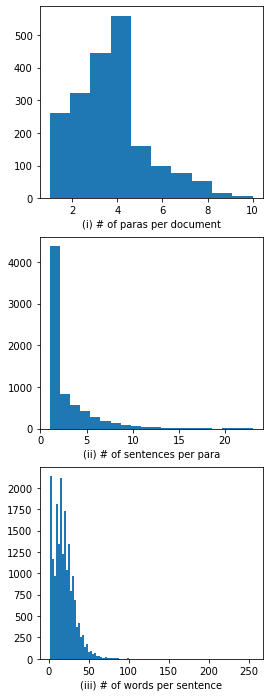

(7051, 19475, 368067)

In [7]:
import seaborn as sns

def get_lengths(data, extra=None):
    if not extra:
        extra = data
    
    doc_lengths = data['tokenized'].map(len)
    para_lengths = pd.Series([
        len(para)
        for doc in data['tokenized']
        for para in doc
    ])
    sent_lengths = pd.Series([
        len(sent)
        for doc in data['tokenized']
        for para in doc
        for sent in para
    ])
    
    return doc_lengths, para_lengths, sent_lengths


d, p, s = get_lengths(train_data)
df = pd.DataFrame({
    "label": (["Paras per document"] * len(d)) \
                + (["para"] * len(p))
})


fig, axes = plt.subplots(3, 1, figsize=(4, 12))
axes[0].hist(d)
axes[0].set_xlabel("(i) # of paras per document")
axes[1].hist(p, bins=20)
axes[1].set_xlabel("(ii) # of sentences per para")
axes[2].hist(s, bins=100)
axes[2].set_xlabel("(iii) # of words per sentence")
plt.show()

sum(d), sum(p), sum(s)

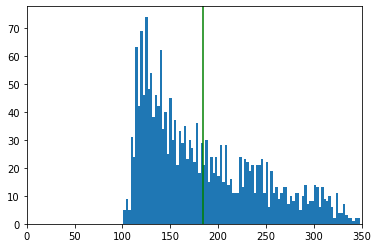

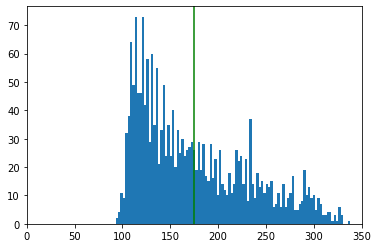

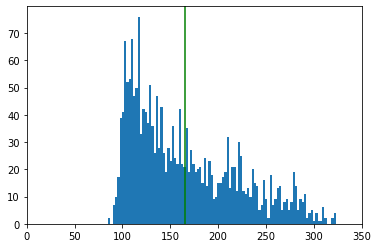

In [8]:
unigram_lengths = train_data['unigrams'].map(len)
bigram_lengths = train_data['bigrams'].map(len)
trigram_lengths = train_data['trigrams'].map(len)

plt.hist(unigram_lengths, bins=100)
plt.axvline(unigram_lengths.mean(), color='green')
plt.xlim(0, 350)
plt.show()

plt.hist(bigram_lengths, bins=100)
plt.axvline(bigram_lengths.mean(), color='green')
plt.xlim(0, 350)
plt.show()

plt.hist(trigram_lengths, bins=100)
plt.axvline(trigram_lengths.mean(), color='green')
plt.xlim(0, 350)
plt.show()

In [9]:
train_data[['label', 'text']].groupby('label').count() / 2000.0

,text
label,
1,0.291
2,0.200
3,0.509


In [10]:
test_data[['label', 'text']].groupby('label').count() / 400.0

,text
label,
1,0.2825
2,0.2200
3,0.4975


In [11]:
test_data = load_pandas(TrainOrTest.TEST, sources=[Source.CLINTON, Source.ENRON])
test_data['label'] = pd.to_numeric(test_data['label'])

print(test_data['label'].unique())

test_data.head()

[3 2 1]


,text,label
0,Madame Secretary:\n\nThank you for reaching ou...,3
1,"Cheryl, Jake,\n\nI received a call from Masood...",3
2,We anticipate the release of what are claimed ...,3
3,Spoke to Ed Levine today to follow up on Frida...,3
4,Purely to update: Tom had me in for lunch at t...,2


In [12]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='unk')
t.fit_on_texts([
    word
    for doc in train_data['text']
    for sent in sent_tokenize(doc)
    for word in word_tokenize(sent)
])

vocab_size = len(t.word_index) + 1

vocab_size, t.word_index['unk']

(18832, 1)

In [13]:
EMBEDDING_DIM = 100

embeddings_index = {}
f = open(os.path.join('data', f'glove.6B.{EMBEDDING_DIM}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word, embeddings_index['unk'])
    embedding_matrix[i] = embedding_vector
        
print(embedding_matrix[72])

Found 400000 word vectors.
[ 1.28830001e-01 -8.22090030e-01  2.74379998e-01 -6.90139979e-02
  1.79890007e-01  7.26050019e-01 -1.51120007e-01  8.55410006e-03
 -9.51219976e-01  7.72430003e-01 -2.83749998e-01  2.83289999e-01
  1.48249999e-01 -1.22300005e-02 -1.92670003e-02 -3.44600007e-02
  3.15059990e-01 -1.66390002e-01 -1.34349996e-02 -2.04590010e-03
  6.49050027e-02 -2.09889993e-01  1.25239998e-01  3.52299988e-01
  6.40399992e-01  5.95699996e-02 -8.03020000e-01 -8.16479981e-01
  6.61339998e-01  5.99699989e-02 -6.15210012e-02  8.49219978e-01
 -2.87330002e-02  2.76699990e-01 -1.00680006e+00  7.17580020e-01
 -3.72570008e-01  4.30640012e-01 -4.92439985e-01  3.86830002e-01
 -3.68279994e-01  2.79820003e-02  1.53460002e+00 -6.05329990e-01
 -3.44489992e-01 -1.70690000e-01  2.92879999e-01 -5.35809994e-01
  5.60350001e-01 -6.30129993e-01 -1.23080000e-01  9.36330035e-02
  5.93360007e-01  1.52139997e+00 -9.26290005e-02 -3.14080000e+00
  1.39310002e-01 -5.38200021e-01  1.17359996e+00  6.23179972e-0

In [14]:
len(set(t.word_index.keys() - embeddings_index.keys()))

1698

In [15]:
example_document = """Dear abby,

I'm writing to tell you you suck. Help me out of this mess.

Bye"""

In [16]:
print(tokenize(example_document))

[[['Dear', 'abby', ',']], [['I', "'m", 'writing', 'to', 'tell', 'you', 'you', 'suck', '.'], ['Help', 'me', 'out', 'of', 'this', 'mess', '.']], [['Bye']]]


In [17]:
print(tokenize(example_document, t))

[[[[310], [1], []]], [[[6], [115], [997], [3], [379], [12], [12], [1], []], [[140], [37], [51], [5], [16], [5216], []]], [[[4542]]]]


In [18]:
train_data['tokenized'] = train_data['text'].map(lambda text: tokenize(text, t))
test_data['tokenized'] = test_data['text'].map(lambda text: tokenize(text, t))

train_data.head()

,text,label,length,tokenized,unigrams,bigrams,trigrams
0,Cheryl:\n\nAre we in a good place to begin pap...,2,1075,"[[[[239], []]], [[[22], [13], [8], [7], [106],...","[(Cheryl,), (:,), (Are,), (we,), (in,), (a,), ...","[(Cheryl, :), (Are, we), (we, in), (in, a), (a...","[(Are, we, in), (we, in, a), (in, a, good), (a..."
1,"Our friend, General Joe Ballard owns The Raven...",2,1408,"[[[[30], [1104], [], [399], [1482], [5415], [2...","[(Our,), (friend,), (,,), (General,), (Joe,), ...","[(Our, friend), (friend, ,), (,, General), (Ge...","[(Our, friend, ,), (friend, ,, General), (,, G..."
2,Outstanding news! Miki Rakic called about 10 m...,3,748,"[[[[1727], [485], []], [[7862], [10654], [240]...","[(Outstanding,), (news,), (!,), (Miki,), (Raki...","[(Outstanding, news), (news, !), (Miki, Rakic)...","[(Outstanding, news, !), (Miki, Rakic, called)..."
3,Responding to separate emails from Uzra + Jeff...,1,648,"[[[[2476], [3], [1134], [2020], [28], [7867], ...","[(Responding,), (to,), (separate,), (emails,),...","[(Responding, to), (to, separate), (separate, ...","[(Responding, to, separate), (to, separate, em..."
4,Guy from Mexico is in NY and is cooperating. D...,1,557,"[[[[1106], [28], [783], [11], [8], [1012], [4]...","[(Guy,), (from,), (Mexico,), (is,), (in,), (NY...","[(Guy, from), (from, Mexico), (Mexico, is), (i...","[(Guy, from, Mexico), (from, Mexico, is), (Mex..."


In [19]:
MAX_DOC_LENGTH = 0
MAX_PARA_LENGTH = 0
MAX_SENT_LENGTH = 0

for doc in train_data['tokenized'].append(test_data['tokenized']):
    MAX_DOC_LENGTH = max(MAX_DOC_LENGTH, len(doc))
    for para in doc:
        MAX_PARA_LENGTH = max(MAX_PARA_LENGTH, len(para))
        for sent in para:
            MAX_SENT_LENGTH = max(MAX_SENT_LENGTH, len(sent))
            
MAX_DOC_LENGTH, MAX_PARA_LENGTH, MAX_SENT_LENGTH

(12, 32, 255)

In [20]:
print(train_data['tokenized'][0])
pad_to_dense(train_data['tokenized'][:1])

[[[[239], []]], [[[22], [13], [8], [7], [106], [225], [3], [606], [3809], [3], [484], [4721], [1653], [57], [118], [14], [10647], [8], [523], []]], [[[27], [43], [], [6], [26], [1054], [13], [318], [67], [3], [248], [14], [523], [1654], [4], [6], [19], [56], [2], [4722], [220], [3], [305], [2], [3809], []], [[69], [19], [17], [1943], [3], [53], [10], [1723], [161], [], [64], [19], [3222], [67], [3], [650], [1317], [10], [2797], [], [4723], [], [10648], [], [298], [], [4], [16], [1723], [121], [667], [19], [2624], [67], [138], [2], [176], [5], [2], [321], [14], [544], [459], [], [3223], []], [[16], [242], [26], [179], [37], [233], [161], [41], [43], [5], [4224], [131], [7], [4225], [1597], [10], [4724], [14], [537], [916], []]], [[[6], [66], [25], [1797], [14], [7860], [51], [3], [4724], [], [2], [2018], [13], [56], [2], [60], [46], [11], [3], [17], [211], [], [4], [13], [74], [25], [56], [2625], [], [4725], [51], [49], [131], [13], [2019], [], [25], [7], [10649], [10650], [1103], [], [

array([[[[239.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[ 22.,  13.,   8., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[ 27.,  43.,   6., ...,   0.,   0.,   0.],
         [ 69.,  19.,  17., ...,   0.,   0.,   0.],
         [ 16., 242.,  26., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        ...,

  

In [21]:
dense_mask(train_data['tokenized'][:1])

array([[[[ True,  True, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[ True,  True,  True, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, Fa

In [22]:
train_tensor = pad_to_dense(train_data['tokenized'])
test_tensor = pad_to_dense(test_data['tokenized'])

train_tensor.shape, test_tensor.shape

((2000, 12, 32, 255), (400, 12, 32, 255))

In [23]:
train_labels = categorical_labels(pd.to_numeric(train_data['label']))
test_labels = categorical_labels(pd.to_numeric(test_data['label']))

train_labels.shape, test_labels.shape

((2000, 3), (400, 3))

In [24]:
train_sent_mask = dense_mask(train_data['tokenized'])
test_sent_mask = dense_mask(test_data['tokenized'])

train_para_mask = np.apply_along_axis(any, 3, train_sent_mask)
test_para_mask = np.apply_along_axis(any, 3, test_sent_mask)

train_doc_mask = np.apply_along_axis(any, 2, train_para_mask)
test_doc_mask = np.apply_along_axis(any, 2, test_para_mask)

(train_sent_mask.shape, train_para_mask.shape, train_doc_mask.shape), (test_sent_mask.shape, test_para_mask.shape, test_doc_mask.shape)

(((2000, 12, 32, 255), (2000, 12, 32), (2000, 12)),
 ((400, 12, 32, 255), (400, 12, 32), (400, 12)))

In [25]:
embedding = tf.keras.layers.Embedding(
    vocab_size,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=False)

embedded_example = embedding(train_tensor[:2])

print(embedded_example.shape)
embedded_example[0][0][0][0]

(2, 12, 32, 255, 100)


<tf.Tensor: id=33, shape=(100,), dtype=float32, numpy=
array([ 0.12616  , -0.2641   ,  0.071929 , -0.96047  , -0.086358 ,
       -0.032276 ,  0.33611  ,  0.55126  , -0.19631  , -0.66443  ,
       -0.16571  , -0.40401  , -0.13921  ,  0.44772  , -0.039273 ,
       -0.63014  , -0.2928   , -0.024373 , -0.81073  ,  0.70829  ,
       -0.47717  ,  0.39068  ,  0.44993  ,  0.25711  ,  0.68318  ,
        0.14003  , -0.013181 , -1.212    , -0.14414  ,  0.21759  ,
        0.30636  ,  0.7272   ,  0.82667  , -0.20531  , -0.68931  ,
       -0.047831 ,  0.3048   ,  0.20761  ,  0.33063  ,  0.33195  ,
       -0.23914  ,  0.046714 , -0.46688  ,  0.46208  ,  0.29071  ,
        0.60412  , -0.75673  , -0.34308  , -0.32161  , -0.17654  ,
        0.66982  ,  0.014476 , -0.12332  , -0.29709  ,  0.26196  ,
       -0.49916  , -0.65069  ,  0.3813   , -0.76894  , -0.2284   ,
       -0.25254  , -0.27246  ,  0.38411  ,  0.52052  ,  0.05651  ,
       -0.49209  ,  1.0191   ,  0.20061  , -0.33445  , -0.0094115,
       

In [26]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_tensor, test_sent_mask, test_para_mask, test_doc_mask), test_labels))

test_dataset = test_dataset.batch(2)

In [27]:
doc_model = DocModel(150, 300, 0.5, embedding_matrix, vocab_size)
small_doc_model = SmallDocModel(150, 300, 0.5, embedding_matrix, vocab_size)
att_doc_model = AttentiveDocModel(150, 300, 200, 0.5, embedding_matrix, vocab_size)
small_att_doc_model = SmallAttentiveDocModel(150, 300, 100, 0.5, embedding_matrix, vocab_size)

for model in (doc_model, small_doc_model, att_doc_model, small_att_doc_model):
    model.compile(optimizer='adam', metrics=['accuracy'],
                  loss=tf.keras.losses.CategoricalCrossentropy())
    model(next(iter(test_dataset))[0])

att_doc_model.load_weights('./checkpoints/attentive_doc_model')
small_att_doc_model.load_weights('./small_att_doc_model/ckpt')
doc_model.load_weights('./doc_model_checkpoint/ckpt')
small_doc_model.load_weights('./small_doc_model_checkpoint/ckpt')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

doc_model.evaluate(test_dataset)
small_doc_model.evaluate(test_dataset)
att_doc_model.evaluate(test_dataset)
small_att_doc_model.evaluate(test_dataset)

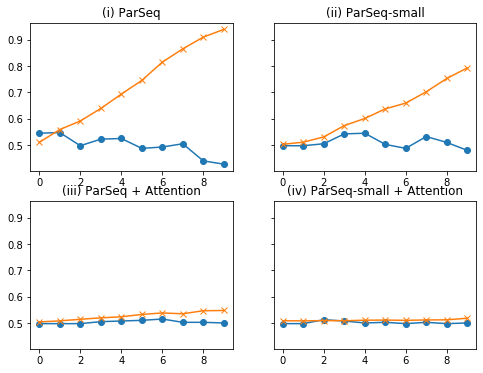

In [29]:
with open('doc_model_history.json') as f:
    doc_model_hist = json.load(f)
with open('small_doc_model_history.json') as f:
    small_doc_model_hist = json.load(f)
with open('best_att_doc_model_history.json') as f:
    att_doc_model_hist = json.load(f)
with open('best_small_att_doc_model_history.json') as f:
    small_att_doc_model_hist = json.load(f)

def plot_hist(ax, model_hist, model_name):
    ax.plot(model_hist['val_accuracy'], 'o-')
    ax.plot(model_hist['accuracy'], 'x-')
    ax.set_title(model_name)
    
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey=True)
plot_hist(axes[0][0], doc_model_hist, "(i) ParSeq")
plot_hist(axes[0][1], small_doc_model_hist, "(ii) ParSeq-small")
plot_hist(axes[1][0], att_doc_model_hist, "(iii) ParSeq + Attention")
plot_hist(axes[1][1], small_att_doc_model_hist, "(iv) ParSeq-small + Attention")

In [30]:
test_data['att_label'] = tf.math.argmax(att_doc_model.predict(test_dataset), axis=1).numpy()
test_data

,text,label,tokenized,att_label
0,Madame Secretary:\n\nThank you for reaching ou...,3,"[[[[1663], [85], []]], [[[168], [12], [10], [2...",2
1,"Cheryl, Jake,\n\nI received a call from Masood...",3,"[[[[239], [], [388], []]], [[[6], [270], [7], ...",2
2,We anticipate the release of what are claimed ...,3,"[[[[13], [1966], [2], [624], [5], [54], [22], ...",2
3,Spoke to Ed Levine today to follow up on Frida...,3,"[[[[303], [3], [1194], [1], [89], [3], [447], ...",2
4,Purely to update: Tom had me in for lunch at t...,2,"[[[[4455], [3], [422], [], [600], [61], [37], ...",0
...,...,...,...,...
395,"Wolak makes some good points. In ERCOT, Enron...",3,"[[[[1], [847], [62], [106], [357], []], [[8], ...",2
396,The reason NBC will not take cash is the prefe...,1,"[[[[2], [773], [2658], [19], [25], [130], [384...",0
397,All GC's\n\nAfter utilizing the Gallup Peak Av...,3,"[[[[35], [9750], [23]]], [[[113], [16267], [2]...",2
398,"Lindy,\n\nJust wanted to let you know that we ...",2,"[[[[5284], []]], [[[68], [157], [3], [95], [12...",0


In [47]:
test_data[test_data['att_label'] == (test_data['label'] - 1)].head(25)

,text,label,tokenized,att_label
0,Madame Secretary:\n\nThank you for reaching ou...,3,"[[[[1663], [85], []]], [[[168], [12], [10], [2...",2
1,"Cheryl, Jake,\n\nI received a call from Masood...",3,"[[[[239], [], [388], []]], [[[6], [270], [7], ...",2
2,We anticipate the release of what are claimed ...,3,"[[[[13], [1966], [2], [624], [5], [54], [22], ...",2
3,Spoke to Ed Levine today to follow up on Frida...,3,"[[[[303], [3], [1194], [1], [89], [3], [447], ...",2
6,"Dear Cheryl,\n\nYou may recall that we met lat...",3,"[[[[310], [239], []]], [[[12], [74], [1219], [...",2
8,Foreign Affairs Day is May 4 and we need to mo...,3,"[[[[314], [412], [121], [11], [74], [244], [4]...",2
12,Per one of the points raised in the Sec's euro...,3,"[[[[397], [65], [5], [2], [357], [853], [8], [...",2
13,Dear Judith:\n\nMy Cairo staff have called jus...,3,"[[[[310], [2400], []]], [[[47], [1546], [228],...",2
14,1. Even those Europeans who might want Blair a...,3,"[[[[105], []], [[210], [185], [4765], [76], [2...",2
21,"You may have heard from Cheryl, but latest fro...",1,"[[[[12], [74], [18], [351], [28], [239], [], [...",0


In [52]:
from IPython.core.display import display, HTML


def att_pred_weights(text):
    tokenized = tokenize(text)
    stuff = [
        train_data.loc[1, "tokenized"],
        tokenize(text, t)
    ]

    padded = pad_to_dense(stuff)
    sent_mask = dense_mask(stuff)
    para_mask = np.apply_along_axis(any, 3, sent_mask)
    doc_mask = np.apply_along_axis(any, 2, para_mask)
    
    pred, sent_weights, para_weights, doc_weights = att_doc_model((padded, sent_mask, para_mask, doc_mask), return_attention_weights=True)
    sent_weights = sent_weights.numpy().reshape((2, 12, 32, 255))[1]
    para_weights = para_weights.numpy().reshape((2, 12, 32))[1]
    doc_weights = doc_weights.numpy().reshape((2, 12))[1]
    
    return np.argmax(pred[1]), tokenized, sent_weights, para_weights, doc_weights


def visualize_att_weights(text):
    pred, tokenized, sent_weights, para_weights, doc_weights = att_pred_weights(text)
    doc_weights = doc_weights[:len(text)] / np.linalg.norm(doc_weights[:len(text)])
    
    partial = f"""<table style="border: 1px solid black;">
        <tr><td>{pred}</td></tr>
        <tr><td>
            <table style="border: 1px solid black;">"""
    
    for wt, para_wts, sents_wts, para in zip(doc_weights, para_weights, sent_weights, tokenized):
        para_wts = para_wts[:len(text)] / np.linalg.norm(para_wts[:len(para)])
        partial += f"""
                <tr>
                    <td style="background-color: rgba(255, 0, 0, {wt:2f})"></td>
                    <td>
                        <table style="border: 1px solid black;">"""
        for wt, sents_wts2, sent in zip(para_wts, sents_wts, para):
            sents_wts2 = sents_wts2[:len(sent)] / np.linalg.norm(sents_wts2[:len(sent)])
            partial += f"""
                            <tr>
                                <td style="background-color: rgba(255, 0, 0, {wt:2f})"></td>
                                <td>
                                    <table style="border: 1px solid black;">
                                        <tr>"""
            for wt, word in zip(sents_wts2, sent):
                partial += f"""
                                            <td style=\"background-color: rgba(255, 0, 0, {wt:2f})\">{word}</td>"""
            partial += """
                                        </tr>
                                    </table>
                                </td>
                            </tr>"""
        partial += """
                        </table>
                    </td>
                </tr>"""
    
    return partial + """
            </table>
        </td></tr>
    </table>"""

#print(visualize_att_weights(test_data.loc[399, 'text']))
#print(visualize_att_weights(test_data.loc[394, 'text']))